In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#cd /content/drive/MyDrive/ManifoldClocks

In [2]:
import numpy as np
import pandas as pd

H5_FOLDER = 'data/sapiens'  # Replace with your directory

# Load endothelial data
endo_X = np.load(f'{H5_FOLDER}/TS_endothelial_filtered.npy')
endo_genes = np.load(f'{H5_FOLDER}/TS_endothelial_filtered_genes.npy')
endo_y = pd.read_csv(f'{H5_FOLDER}/TS_endothelial_meta.csv', index_col=0)

# Load epithelial data
epi_X = np.load(f'{H5_FOLDER}/TS_epithelial_filtered.npy')
epi_genes = np.load(f'{H5_FOLDER}/TS_epithelial_filtered_genes.npy')
epi_y = pd.read_csv(f'{H5_FOLDER}/TS_epithelial_meta.csv', index_col=0)

# Load stromal data
stro_X = np.load(f'{H5_FOLDER}/TS_stromal_filtered.npy')
stro_genes = np.load(f'{H5_FOLDER}/TS_stromal_filtered_genes.npy')
stro_y = pd.read_csv(f'{H5_FOLDER}/TS_stromal_meta.csv', index_col=0)

# Identify common genes
common_genes = np.intersect1d(np.intersect1d(endo_genes, epi_genes), stro_genes)

# Get indices of common genes in each dataset
endo_indices = np.where(np.isin(endo_genes, common_genes))[0]
epi_indices = np.where(np.isin(epi_genes, common_genes))[0]
stro_indices = np.where(np.isin(stro_genes, common_genes))[0]

# Filter each dataset to include only the common genes
endo_X_filtered = endo_X[:, endo_indices]
epi_X_filtered = epi_X[:, epi_indices]
stro_X_filtered = stro_X[:, stro_indices]

# Combine the filtered expression data and metadata
combined_X = np.vstack([endo_X_filtered, epi_X_filtered, stro_X_filtered])
combined_y = pd.concat([endo_y, epi_y, stro_y])

# Save the combined data
np.save(f'{H5_FOLDER}/TS_EES_filtered.npy', combined_X)
np.save(f'{H5_FOLDER}/TS_EES_filtered_genes.npy', common_genes)
combined_y.to_csv(f'{H5_FOLDER}/TS_EES_meta.csv')

print("Combined data saved successfully.")


Combined data saved successfully.


### GO onotlogy

In [2]:
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
from copy import deepcopy
from umap import UMAP
pd.set_option('display.max_columns', 100)

In [3]:
import numpy as np
import pandas as pd

# Assuming shap_values_train and test_data_split are already loaded

def get_gene_lists(shap_values_train, feature_names):
    # Convert SHAP values and feature values to numpy arrays for easier manipulation
    shap_values_array = np.array(shap_values_train)
    feature_values_array = np.array(test_data_split)

    # Initialize a list to store the names of upregulated genes
    upregulated_genes = []
    downregulated_genes = []
    uncertain_genes = []

    # Define the threshold for high expression (e.g., 75th percentile)
    threshold_percentile = 75

    # Loop over each feature (gene)
    for i in range(feature_values_array.shape[1]):
        # Extract the SHAP values and feature values for the current gene
        shap_values_gene = shap_values_array[:, i]
        feature_values_gene = feature_values_array[:, i]
        
        # Identify the cells where the gene expression is high
        high_feature_threshold = np.percentile(feature_values_gene, threshold_percentile)
        high_feature_indices = feature_values_gene > high_feature_threshold
        
        # Extract the SHAP values for these high expression cells
        shap_values_high_feature = shap_values_gene[high_feature_indices]
        
        # Check if the majority of SHAP values are positive in high expression cells
        if np.mean(shap_values_high_feature > 0) > 0.5:
            upregulated_genes.append(feature_names[i])
        elif np.mean(shap_values_high_feature < 0) > 0.5:
            downregulated_genes.append(feature_names[i])
        else:
            uncertain_genes.append(feature_names[i])


    # Calculate the sum of absolute SHAP values for each feature
    feature_sums = np.sum(np.abs(shap_values_train), axis=0)

    # Get the indices that would sort the feature sums in descending order
    feature_order = np.argsort(feature_sums)[::-1]

    # Get the feature names in the right order
    ordered_feature_names = [feature_names[i] for i in feature_order]

    # Get the feature sums in the right order
    ordered_feature_sums = feature_sums[feature_order]

    # Create lists to store the ordered upregulated and downregulated genes
    ordered_upregulated_genes = []
    ordered_downregulated_genes = []

    # Create lists to store the ordered feature sums for upregulated and downregulated genes
    ordered_upregulated_sums = []
    ordered_downregulated_sums = []

    # Iterate over the ordered feature names and sums
    for name, sum_value in zip(ordered_feature_names, ordered_feature_sums):
        if name in upregulated_genes:
            ordered_upregulated_genes.append(name)
            ordered_upregulated_sums.append(sum_value)
        elif name in downregulated_genes:
            ordered_downregulated_genes.append(name)
            ordered_downregulated_sums.append(sum_value)

    # # Print the ordered upregulated genes and their corresponding sums
    # print("Ordered Upregulated Genes:")
    # for name, sum_value in zip(ordered_upregulated_genes, ordered_upregulated_sums):
    #     print(f"{name}: {sum_value}")

    # # Print the ordered downregulated genes and their corresponding sums
    # print("Ordered Downregulated Genes:")
    # for name, sum_value in zip(ordered_downregulated_genes, ordered_downregulated_sums):
    #     print(f"{name}: {sum_value}")

    return ordered_feature_names, ordered_upregulated_genes, ordered_downregulated_genes, ordered_feature_sums, ordered_upregulated_sums, ordered_downregulated_sums


def load_data(dataset='default', tissue='None', filtered=True, normalize=False, verbose=True):
    #if dataset == 'default':
    #    gene_list = None
    #    X = np.load('data/default/processed_data.npy')
    #    metadata = pd.read_csv('data/default/metainfo.csv', index_col=0)

    #elif dataset == 'h5ad' or dataset == 'sapiens':
    H5_FOLDER = f'data/{dataset}'
    tissue = tissue

    if filtered:
        df_type = 'filtered'
    else:
        df_type = 'full'

    gene_list = np.load(f'{H5_FOLDER}/{tissue}_{df_type}_genes.npy')
    X = np.load(f'{H5_FOLDER}/{tissue}_{df_type}.npy')
    metadata = pd.read_csv(f'{H5_FOLDER}/{tissue}_meta.csv', index_col=0)
        
    y = deepcopy(metadata)
    
    if normalize:
        X = np.log1p(X)
        if verbose:
            print('Data normalized.')
    
    if verbose:
        print(f'Data shape: {X.shape}')

    return (X, y, gene_list)


def tt_split_setup(full_X, full_y, test_size=0.20, random_state=42, donor_test_list=None):
    if donor_test_list is None:
        X_train, X_test, y_train, y_test = train_test_split(full_X, full_y, test_size=0.20, random_state=42)
    else:
        X_train = full_X[~full_y.donor.isin(donor_test_list)]
        y_train = full_y[~full_y.donor.isin(donor_test_list)]
        X_test = full_X[full_y.donor.isin(donor_test_list)]
        y_test = full_y[full_y.donor.isin(donor_test_list)]
    return X_train, X_test, y_train, y_test


import matplotlib.pyplot as plt
import numpy as np

def print_features_above_threshold(ordered_feature_names, ordered_feature_sums, threshold, plot=True):
    above_threshold_names = [name for name, sum_value in zip(ordered_feature_names, ordered_feature_sums) if sum_value > threshold]
    above_threshold_sums = [sum_value for sum_value in ordered_feature_sums if sum_value > threshold]
    count = len(above_threshold_names)
    
    print(f"Number of features above the threshold ({threshold}): {count}")
    print("Features above the threshold:")
    # for feature in above_threshold_names:
    #     print(feature)

    if plot:
        # Create a violin plot for features above the threshold
        plt.figure(figsize=(10, 6))
        plt.violinplot(above_threshold_sums, vert=False, widths=0.7, showmeans=True, showextrema=True, showmedians=True)
        plt.xlabel('Sum of Absolute SHAP Values')
        plt.title('Distribution of Feature Importance (Above Threshold)')
        plt.tight_layout()
        plt.show()
        
        # Create a histogram for features above the threshold
        plt.figure(figsize=(10, 6))
        plt.hist(above_threshold_sums, bins=30, edgecolor='black')
        plt.xlabel('Sum of Absolute SHAP Values')
        plt.ylabel('Frequency')
        plt.title('Distribution of Feature Importance (Above Threshold)')
        plt.tight_layout()
        plt.show()

    return above_threshold_names

# Get categories in metadata for given or default targets
def summarize_metadata(metadata, targets = ['organ_tissue',
                                            'method',
                                            'donor',
                                            'cell_ontology_class',
                                            'free_annotation',
                                            'gender',
                                            'compartment',
                                            'age']):
    columns = metadata.columns
    for column in targets:
        if column in columns:
            print(column)
            result = dict()
            for name in metadata[column].unique():
                result[name] = len(metadata[metadata[column] == name])
            result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))  
            for key, value in result.items():
                print(f"{key}: {value}")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data: pd.DataFrame, col1: str, col2: str, min_count_col1: int = None, min_count_col2: int = None):
    """
    Plot a heatmap indicating the number of cells for each crossing of the categories in col1 and col2.
    If min_count_col1 and/or min_count_col2 are provided, filter out categories in col1 and/or col2 with counts less than the respective thresholds.
    
    Parameters:
    data (pd.DataFrame): The single-cell data.
    col1 (str): The name of the first column to use for the x-axis.
    col2 (str): The name of the second column to use for the y-axis.
    min_count_col1 (int, optional): Minimum count threshold to filter categories in col1.
    min_count_col2 (int, optional): Minimum count threshold to filter categories in col2.
    """
    if min_count_col1 is not None:
        # Filter the data based on the minimum count threshold for col1
        counts_col1 = data[col1].value_counts()
        valid_categories_col1 = counts_col1[counts_col1 >= min_count_col1].index
        data = data[data[col1].isin(valid_categories_col1)]
    
    if min_count_col2 is not None:
        # Filter the data based on the minimum count threshold for col2
        counts_col2 = data[col2].value_counts()
        valid_categories_col2 = counts_col2[counts_col2 >= min_count_col2].index
        data = data[data[col2].isin(valid_categories_col2)]
    
    # Create a cross-tabulation of the two columns
    heatmap_data = pd.crosstab(data[col1], data[col2])

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="viridis")
    plt.title(f'Heatmap of {col1} vs {col2}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

# Example usage:
# Assuming 'df' is your DataFrame and 'Category1' and 'Category2' are the columns you want to plot
# plot_heatmap(df, 'Category1', 'Category2', min_count_col1=10, min_count_col2=20)



## SAPIENCS

In [4]:
X, y, gene_list = load_data('sapiens',
                            'TS_EES',)

Data shape: (218317, 51078)


In [12]:
def variance_thresholding(X, threshold=0.01, chunk_size=1000):
    num_samples, num_features = X.shape
    retained_indices = []

    for start in range(0, num_features, chunk_size):
        end = min(start + chunk_size, num_features)
        chunk = X[:, start:end]
        variances = np.var(chunk, axis=0)
        retained_indices.extend(np.where(variances > threshold)[0] + start)
    
    return retained_indices

# Apply variance thresholding
threshold = 0.05  # Example threshold value
retained_indices = variance_thresholding(X, threshold=threshold)

# Filter the data
X_high_variance = X[:, retained_indices]
gene_list_high_variance = gene_list[retained_indices]


In [13]:
X_high_variance.shape

(218317, 6926)

In [14]:
# Save the filtered data
H5_FOLDER = 'data/sapiens'  # Replace with your directory
np.save(f'{H5_FOLDER}/TS_EES_hv_filtered.npy', X_high_variance)
np.save(f'{H5_FOLDER}/TS_EES_hv_filtered_genes.npy', gene_list_high_variance)
y.to_csv(f'{H5_FOLDER}/TS_EES_hv_meta.csv')

: 

X_high_variance.shape

In [ ]:
import pandas as pd
df = pd.read_hdf('dataframe.h5', key='df')
age_markers = list(df.columns[:1000])

In [18]:
# Find the common genes between gene_list and age_markers
common_genes = np.intersect1d(gene_list, age_markers)

# Find the indices of these common genes in the original gene_list
gene_indices = np.where(np.isin(gene_list, common_genes))[0]

# Filter the numpy array X to include only the columns that correspond to the common genes
X_filtered = X[:, gene_indices]

gene_list_filtered = gene_list[gene_indices]

Data shape: (104148, 56126)


In [20]:
X_filtered.shape

(104148, 1000)

In [22]:
H5_FOLDER = f'data/sapiens'

# Save the new sets of X, y, and gene_list with the prefix CHOSEN_epithelial
np.save(f'{H5_FOLDER}/CHOSEN_epithelial_filtered.npy', X_filtered)
np.save(f'{H5_FOLDER}/CHOSEN_epithelial_filtered_genes.npy', common_genes)
y.to_csv(f'{H5_FOLDER}/CHOSEN_epithelial_meta.csv')

In [39]:
y

,organ_tissue,method,donor,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,gender,age
cell_id,,,,,,,,,,,,
AAACGCTCAACGGCTC_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,7787.0,2983,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male,67
AAAGGATCAAATCAGA_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,8694.0,3016,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male,67
AACCTGACACGCGTCA_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,3740.0,1579,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male,67
AACGAAAGTGATGTAA_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,5742.0,2280,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male,67
AACTTCTCAGTGCCTG_TSP6_Liver_NA_10X_1_1,Liver,10X,TSP6,NaN,4649.0,1403,endothelial cell of hepatic sinusoid,Endothelial,True,endothelial,male,67
...,...,...,...,...,...,...,...,...,...,...,...,...
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P3_S99,Vasculature,smartseq2,TSP2,NaN,308152.0,2090,fibroblast,fibroblast,True,stromal,female,61
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P7_S103,Vasculature,smartseq2,TSP2,NaN,387043.0,2132,fibroblast,fibroblast,True,stromal,female,61
TSP2_Vasculature_aorta_SS2_B114585_B133324_Stromal_P9_S105,Vasculature,smartseq2,TSP2,NaN,412608.0,3140,fibroblast,fibroblast,True,stromal,female,61


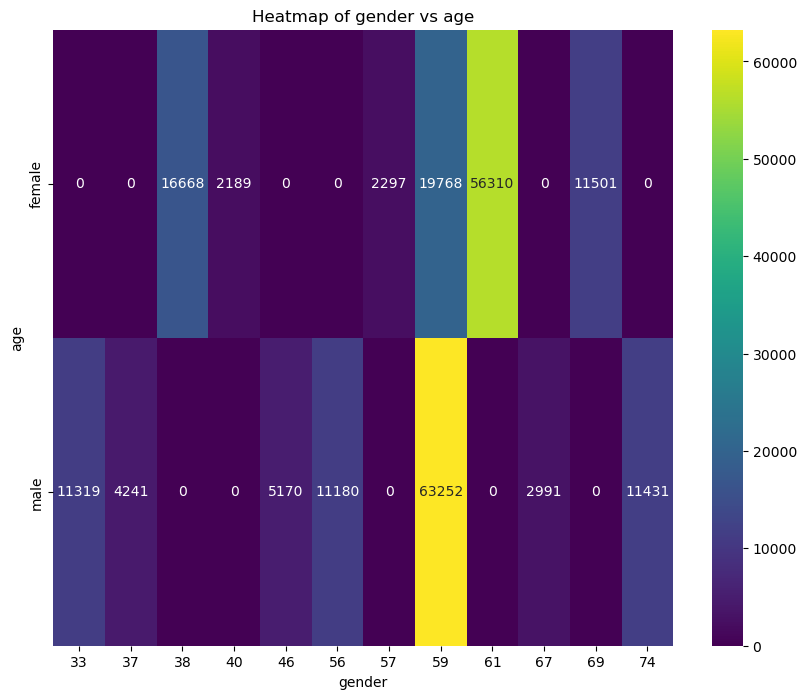

: 

In [41]:
plot_heatmap(y, "gender","age", min_count_col1=500)

TSP6 -- 67
TSP7 -- 69
TSP4 -- 38
TSP5 -- 40
TSP3 -- 57
TSP10 -- 33
TSP12 -- 74
TSP9 -- 37
TSP8 -- 56
TSP14 -- 59
TSP15 -- 46
TSP1 -- 59 :rep
TSP2 -- 61
33 37 38 40 46 56 57 59 59 61 67 69 74


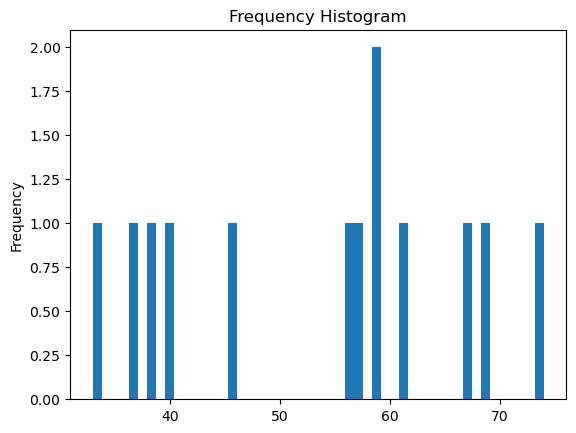

In [6]:
def summarize_age_donor(metadata, full=False):
    ages = [59, 61, 57, 38, 40, 67, 69, 56, 37, 33, 42, 74, 22, 59, 46]  
    age_set = list()
    for donor_id in metadata['donor'].unique():
        age = ages[int(donor_id[3:])-1]
        if age in age_set:
            if full:
                print(f'{donor_id} -- {age} :rep')
            else:
                print(f'{age} :rep')
            age_set.append(age)
        else:
            age_set.append(age)
            if full:
                print(f'{donor_id} -- {age}')
    print(*sorted(age_set))
    plt.hist(age_set, bins=50)
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency')

summarize_age_donor(y, full=True)

In [11]:
summarize_metadata(y)

# organ_tissue -> tissue
# method -> confounder
# donor -> train/test
# cell_ontology_class

organ_tissue
Lung: 13981
Salivary_Gland: 13090
Prostate: 12316
Tongue: 12062
Kidney: 8331
Pancreas: 8215
Eye: 7877
Large_Intestine: 6220
Mammary: 5854
Trachea: 5047
Bladder: 4151
Small_Intestine: 3712
Liver: 1600
Heart: 1089
Uterus: 293
Thymus: 178
Skin: 106
Vasculature: 26
method
10X: 99502
smartseq2: 4646
donor
TSP14: 30601
TSP2: 25374
TSP8: 10185
TSP1: 10139
TSP7: 9440
TSP4: 6316
TSP15: 3736
TSP3: 2175
TSP9: 2005
TSP5: 1966
TSP12: 1089
TSP6: 1021
TSP10: 101
cell_ontology_class
basal cell: 14065
acinar cell of salivary gland: 10147
type ii pneumocyte: 9146
epithelial cell: 8951
kidney epithelial cell: 8331
pancreatic acinar cell: 5534
luminal epithelial cell of mammary gland: 5378
conjunctival epithelial cell: 4587
bladder urothelial cell: 4151
keratinocyte: 3667
basal cell of prostate epithelium: 3298
enterocyte of epithelium of large intestine: 2764
hepatocyte: 2647
pancreatic ductal cell: 2431
duct epithelial cell: 1693
corneal epithelial cell: 1488
immature enterocyte: 1288
matur

In [37]:
import pandas as pd

# Donor ages provided
ages = {
    'TSP6': 67, 'TSP7': 69, 'TSP4': 38, 'TSP5': 40,
    'TSP3': 57, 'TSP10': 33, 'TSP12': 74, 'TSP9': 37,
    'TSP8': 56, 'TSP14': 59, 'TSP15': 46, 'TSP1': 59, 'TSP2': 61
}

# Convert the ages to a DataFrame
ages_df = pd.DataFrame(list(ages.items()), columns=['Donor', 'Age'])

# Sort the donors by age
ages_df = ages_df.sort_values(by='Age')

# Divide the donors into three groups: younger, middle, and older
n = len(ages_df)
younger_group = ages_df.iloc[:n//3]
middle_group = ages_df.iloc[n//3:2*n//3]
older_group = ages_df.iloc[2*n//3:]

# Select one donor from each group
selected_test_donors = [
    younger_group.sample(1).iloc[0]['Donor'],
    middle_group.sample(1).iloc[0]['Donor'],
    older_group.sample(1).iloc[0]['Donor']
]

print("Selected Test Donors:", selected_test_donors)

# # Display selected test donors and their details
# test_df = ages_df[ages_df['Donor'].isin(selected_test_donors)]
# test_df


Selected Test Donors: ['TSP5', 'TSP3', 'TSP2']


## MOUSE

In [ ]:
from sklearn.utils import resample

shap_values_deconf = np.load('whole.npy')
shap_values_age = np.load('whole_second.npy')

full_X, full_y, feature_names = load_data(
    dataset='mouse', 
    tissue='BOTH_NOFILTER', 
    filtered=True,
    normalize=False)

donor_tests = ['1-M-62', '3_56_F', '3-M-5/6', '18_53_M', '21_55_F', '24_60_M', '30-M-4']
_, X_test, _, y_test = tt_split_setup(full_X, full_y, donor_test_list=donor_tests)
del full_X, full_y

test_data_split = resample(X_test, n_samples=500, random_state=42)
del X_test, y_test

In [ ]:
shap_values = np.load('whole.npy')

In [ ]:
ordered_feature_names, ordered_upregulated_genes, ordered_downregulated_genes, ordered_feature_sums, ordered_upregulated_sums, ordered_downregulated_sums = get_gene_lists(shap_values_deconf, feature_names)

In [ ]:
TO_PLOT = False
threshold = 15  # Specify the desired threshold value
age_markers = print_features_above_threshold(ordered_feature_names, ordered_feature_sums, threshold, TO_PLOT)
upregulated_age_markers = print_features_above_threshold(ordered_upregulated_genes, ordered_upregulated_sums, threshold, TO_PLOT)
downregulated_age_markers = print_features_above_threshold(ordered_downregulated_genes, ordered_downregulated_sums, threshold, TO_PLOT)

In [ ]:
len(upregulated_age_markers)

In [ ]:
import gseapy

enr_GOMF_up = gseapy.enrichr(gene_list=upregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_up',
    cutoff=0.05
)

enr_GOMF_down = gseapy.enrichr(gene_list=downregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_down',
    cutoff=0.05
)

In [ ]:
from copy import deepcopy
full_X, full_y, feature_names = load_data(
        dataset='mouse', 
        tissue='BOTH_NOFILTER', 
        filtered=True,
        normalize=False)


In [ ]:
del X_train, X_test, y_train, y_test

In [ ]:
donor_tests = ['1-M-62', '3_56_F', '3-M-5/6', '18_53_M', '21_55_F', '24_60_M', '30-M-4']
X_train, X_test, y_train, y_test = tt_split_setup(full_X, full_y, donor_test_list=donor_tests)

In [ ]:
len(y_test.cell_ontology_class.unique())

In [ ]:
# Get the count of each cell_ontology_class
cell_counts = y_test['cell_ontology_class'].value_counts()

# Filter the cell_ontology_class values where the count is higher than 300
selected_classes = cell_counts[cell_counts > 500].index

# Get the unique selected cell_ontology_class values
unique_classes = selected_classes.unique()

print("Unique cell_ontology_class values with count higher than 300:")
print(len(unique_classes))


In [ ]:
import pandas as pd
from gseapy.plot import barplot, dotplot

enr_up_file = '/Users/mindblaze/Desktop/Thesis/clocks/test/enr_Aging_GEO_up/Aging_Perturbations_from_GEO_up.Mouse.enrichr.reports.txt'
enr_up = pd.read_csv(enr_up_file, sep='\t')

barplot(df=enr_up, title='GO MF', color='b')


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# Function to create the network plot
def create_network_plot(df, top_terms=10):
    G = nx.Graph()
    
    # Select top GO terms based on adjusted p-value
    top_df = df.head(top_terms)
    
    for _, row in top_df.iterrows():
        term = row['Term']
        genes = row['Genes'].split(';')
        
        for gene in genes:
            G.add_edge(term, gene)
            
    pos = nx.spring_layout(G)
    
    plt.figure(figsize=(14, 10))
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    
    plt.title("Network of Top Enriched GO Terms")
    plt.show()


def create_network_plot_ext(df, input_genes_list=None, top_terms=10, pval_threshold=0.05, max_genes_per_node=100):
    G = nx.Graph()

    # Filter by p-value threshold
    filtered_df = df[df['Adjusted P-value'] <= pval_threshold]

    if input_genes_list is not None:
        input_genes = list(map(str.upper, input_genes_list))
    
    # Select top GO terms based on adjusted p-value
    top_df = filtered_df.head(top_terms)
    
    node_colors = {}
    node_sizes = {}
    
    for _, row in top_df.iterrows():
        term = row['Term']
        genes = row['Genes'].split(';')

        # Limit the number of genes per node
        genes = genes[:max_genes_per_node]
        
        # Only add edges for genes that are in the input gene list
        for gene in genes:
            G.add_edge(term, gene)
            # Assign color and size based on whether the node is a term or a gene
            if term not in node_colors:
                node_colors[term] = 'skyblue'
                node_sizes[term] = 1000  # Size for GO terms
            node_colors[gene] = 'salmon'
            node_sizes[gene] = 500  # Size for genes

    pos = nx.spring_layout(G)
    
    # Get color and size lists for nodes
    node_color_list = [node_colors[node] for node in G.nodes]
    node_size_list = [node_sizes[node] for node in G.nodes]
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=node_size_list, node_color=node_color_list,
        font_size=10, font_weight='bold', edge_color="gray")
    
    plt.title(f"Network of Top Enriched GO Terms (p-value <= {pval_threshold})")
    plt.show()

# Create the network plot
#create_network_plot(enr_up, top_terms=10)
create_network_plot_ext(enr_up, top_terms=10, pval_threshold=0.005, max_genes_per_node=15)

In [ ]:
import gseapy

enr_GOMF_up = gseapy.enrichr(gene_list=upregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_up',
    cutoff=0.05
)

enr_GOMF_down = gseapy.enrichr(gene_list=downregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_down',
    cutoff=0.05
)

In [ ]:
import gseapy

enr_GOMF_up = gseapy.enrichr(gene_list=upregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_up',
    cutoff=0.05
)

enr_GOMF_down = gseapy.enrichr(gene_list=downregulated_age_markers,
    gene_sets=['GO_Molecular_Function_2023'],
    organism='Mouse', 
    outdir='seconded/enr_GOMF_down',
    cutoff=0.05
)

# Preprocess raw bulk data

In [ ]:
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
from copy import deepcopy
from umap import UMAP
pd.set_option('display.max_columns', 100)

In [ ]:
# units = pickle.load(open('data/default/units.pickle', 'rb')) # 25 datasets with unit of time for each
# expr = pickle.load(open('data/default/exprdict.pickle', 'rb'))
# pheno = pickle.load(open('data/default/phenodict.pickle', 'rb')) # Info about samples in each dataset

In [ ]:
#extract human data only
from itertools import chain 
human_keys = [k for k in expr.keys() if k.__contains__('Human')]
df = pd.concat([expr[k] for k in human_keys], axis=1)
age = list(chain.from_iterable([pheno[k]['Age'].tolist() for k in human_keys]))
metainfo = list(chain.from_iterable([[k] * expr[k].shape[1] for k in expr.keys() if k.__contains__('Human')]))

# filter for numeric ages (some are simply indicated as "young" or "old")
mask = []
for a in age:
    try:
        float(a)
        mask.append(True)
    except:
        mask.append(False)

df = df.iloc[:, mask]
age = np.array(age)[mask].astype(float)
metainfo = np.array(metainfo)[mask]

metainfo = pd.DataFrame(list(map(lambda x: x.split('_'), metainfo)), 
                        columns=['species', 'source', 'tissue', 'sex']).drop('species', 1)
metainfo['age'] = age

metainfo.to_csv('data/default/metainfo.csv')

In [ ]:
# prepare data
##  possible problem: data were log transformed and centered across genes within a sample (the original paper do not assume such a transformation)

# Data 
nan_share_threshold = 0.2
gene_mask = (df.isna().sum(1) / df.shape[1]) < nan_share_threshold
print("%.3f%% genes hold" % (gene_mask.sum() / df.shape[0] * 100))
tdf = df.loc[gene_mask, :] #remain only genes passing the threshold above
tdf = tdf.fillna(0) #fill na with zeros
tdf = tdf.subtract(tdf.mean(1), axis=0).divide(tdf.std(1), axis=0) #mean centering and std scaling

processed_data = tdf.T.to_numpy()
np.save('data/default/processed_data.npy', processed_data)

In [ ]:
# NOT USED dimensionality reduction with K-means (WHY???)
def kmeans():
        from sklearn.cluster import KMeans
        clust = KMeans(n_clusters=900, 
                #init='k-means++', # == default
                #n_init=10, # == default
                #max_iter=300, # == default
                #tol=1e-4, # == default
                verbose=1000, # ???
                #random_state=None, # == default
                #copy_x=True # == default
                )
        clust.fit(tdf)

        #tdf_clusters = clust.cluster_centers_
        #np.save('data/gene_clusters.npy', tdf_clusters)

# Preprocess sc h5ad data

### NEW 

In [25]:
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
from copy import deepcopy
pd.set_option('display.max_columns', 100)

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from math import isinf
#import pickle
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from copy import deepcopy
from umap import UMAP

In [ ]:
data_path = '/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/E-MTAB-8077-quantification-raw-files/E-MTAB-8077.aggregated_filtered_counts.mtx'

import numpy as np
import re
from scipy.io import mmread

# Read the .mtx file using scipy.io.mmread()
sparse_matrix = mmread(data_path)

# Convert the sparse matrix to a dense NumPy array
expression_data = sparse_matrix.toarray().T


with open(data_path+'_rows', 'r') as file:
    gene_names = file.read().splitlines()
gene_names = [gene.split('\t')[0] for gene in gene_names]


# Read the cell names
with open(data_path+'_cols', 'r') as file:
    cell_names = file.read().splitlines()

metadata_path = '/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/E-MTAB-8077-quantification-raw-files/ExpDesign-E-MTAB-8077.tsv'

with open(metadata_path) as file:
    metadata = pd.read_csv(file, sep='\t')

# Function to extract text within square brackets
def extract_bracket_text(text):
    match = re.search(r'\[(.*?)\]', text)
    return match.group(1) if match else text

# Rename columns to only have the parts within square brackets
metadata.columns = [extract_bracket_text(col) for col in metadata.columns]

# Handle duplicates by appending a suffix to duplicate names
def handle_duplicates(cols):
    counts = {}
    new_cols = []
    for col in cols:
        if col in counts:
            counts[col] += 1
            new_cols.append(f"{col}.{counts[col]}")
        else:
            counts[col] = 0
            new_cols.append(col)
    return new_cols

new_columns = [extract_bracket_text(col) for col in metadata.columns]

# Apply the function to handle duplicates
metadata.columns = handle_duplicates(new_columns)

# Remove duplicated rows based on the 'ENA_SAMPLE' column
#metadata = metadata.drop_duplicates(subset='ENA_SAMPLE')

# Print the shape of the resulting NumPy array
print("Expression data shape:", expression_data.shape)

# Print the number of genes and cells
print("Number of genes:", len(gene_names))
print("Number of cells:", len(cell_names))

In [ ]:
metadata

In [ ]:
metadata.age.unique()
metadata['age'] = 2

In [ ]:
# expression_data = expression_data[metadata.genotype == "wild type"]
# metadata = metadata[metadata.genotype == "wild type"]

In [ ]:
import mygene

mg = mygene.MyGeneInfo()

# Query gene symbols using Ensembl gene IDs
gene_info = mg.querymany(gene_names, scopes='ensembl.gene', fields='symbol', species='mouse')

# Create a dictionary to store the mapping of Ensembl gene IDs to gene symbols
gene_id_to_symbol = {}

# Iterate over the query results and populate the dictionary
for gene in gene_info:
    ensembl_id = gene.get('query')
    symbol = gene.get('symbol')
    
    if ensembl_id and symbol:
        gene_id_to_symbol[ensembl_id] = symbol

# Create a list to store the gene symbols without duplicates
gene_symbols = []

# Iterate over the original gene names and retrieve the corresponding gene symbols
for gene_id in gene_names:
    symbol = gene_id_to_symbol.get(gene_id, 'N/A')
    gene_symbols.append(symbol)

# Print the number of genes and the number of genes with no hit
print(f"Total genes: {len(gene_names)}")
print(f"Genes with no hit: {gene_symbols.count('N/A')}")


In [ ]:
folder = 'data/mouse'
tissue = '8077'

metadata.to_csv(f'{folder}/{tissue}_meta.csv')
np.save(f'{folder}/{tissue}_filtered_genes.npy', gene_symbols)
np.save(f'{folder}/{tissue}_filtered.npy', expression_data)

### OLD

In [26]:
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
from copy import deepcopy
pd.set_option('display.max_columns', 100)

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from math import isinf
#import pickle
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from copy import deepcopy
from umap import UMAP

In [27]:
def plot_pca(data, meta, color=None):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data)

    #plt.figure(figsize=(7,6))
    #sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1])

    if color:
        for category in color:
            plt.figure(figsize=(7,6))
            sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=meta[category])

def plot_umap(data, meta, color=None, partial_fit=1.0, figsize=(7, 6)):
    umap = UMAP(n_components=2)
    #fit_data, fit_meta, left_data, left_meta = train_test_split()
    reduced = umap.fit_transform(data)

    #plt.figure(figsize=(7,6))
    #sns.scatterplot(x=redu
    # ced[:, 0], y=reduced[:, 1])

    if color:
        for category in color:
            plt.figure(figsize=figsize)
            sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=meta[category])

def prepare_raw_from_h5ad(data, debug=False):
        matrix = pd.DataFrame(data.X.todense())
        matrix.columns = data.var.index
        matrix.index = data.obs.index
        metadata = data.obs
        if debug:
            print(f'Prepared matrix with shape {matrix.shape}')
        return (matrix, metadata)

def process_h5ad(folder, tissue, threshold=0.2, only_filtered=False):

    # Process h5 data
    h5raw = sc.read_h5ad(f'{folder}/{tissue}.h5ad')
    sc.pp.normalize_total(h5raw, target_sum=1e4)
    sc.pp.log1p(h5raw, base=10)

    # PCR by scanpy
    #sc.tl.pca(h5raw)
    #sc.pl.pca(h5raw, color=['method', 'age', 'sex'], title=f'PCA: lung', save='result.png')

    def prepare_raw_from_h5ad(data, debug=False):
        matrix = pd.DataFrame(data.X.todense())
        matrix.columns = data.var.index
        matrix.index = data.obs.index
        metadata = data.obs
        if debug:
            print(f'Prepared matrix with shape {matrix.shape}')
        return (matrix, metadata)

    h5_data, metadata = prepare_raw_from_h5ad(h5raw)
    #h5_input = h5_data.to_numpy()

    if not only_filtered:
        np.save(f'{folder}/{tissue}_full_genes.npy', list(h5_data.columns))
        np.save(f'{folder}/{tissue}_full.npy', h5_data)

    # Add age info into metadata
    ages = [59, 61, 57, 38, 40, 67, 69, 56, 37, 33, 42, 74, 22, 59, 46]
    donor2age = {f'TSP{i+1}':j for i, j in enumerate(ages)}
    metadata['age'] = metadata.apply(lambda row: donor2age[row.donor], axis=1)

    metadata.to_csv(f'{folder}/{tissue}_meta.csv')
    

    # Remove all genes which are expressed in less than X of cells
    # Very robust and straightforward way to reduce # features
    cell_threshold = int(h5_data.shape[0] * threshold)
    filtered_data = (h5_data.loc[:,h5_data.astype(bool).sum(axis=0) > cell_threshold])
    filt_input = filtered_data.to_numpy()

    np.save(f'{folder}/{tissue}_filtered_genes.npy', list(filtered_data.columns))
    np.save(f'{folder}/{tissue}_filtered.npy', filt_input)

## Mice

In [ ]:
for file_path in glob.glob("droplet_*"):
    print(file_path)

In [ ]:
import glob
import os
# for file_path in glob.glob("/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/*droplet*"):
#     os.rename(file_path, '/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/droplet_'+file_path.split('-')[-1])
    
# for file_path in glob.glob("/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/*facs*"):
#     os.rename(file_path, '/Users/mindblaze/Desktop/Thesis/clocks/data/mouse/facs_'+file_path.split('-')[-1])

droplet_paths = glob.glob("data/mouse/*droplet*")
facs_paths = glob.glob("data/mouse/*facs*")
print(droplet_paths)

droplet_tissues = set()
facs_tissues = set()
for file_path in droplet_paths:
    droplet_tissues.add(file_path.split("droplet_")[-1].split(".")[0])
for file_path in facs_paths:
    facs_tissues.add(file_path.split("facs_")[-1].split(".")[0])

both_tissues = droplet_tissues.intersection(facs_tissues)
print(len(droplet_tissues), len(facs_tissues), len(both_tissues))

both_tissues = list(both_tissues)
droplet_only_tissues = droplet_tissues - facs_tissues
facs_only_tissues = facs_tissues - droplet_tissues

In [ ]:
all_tissues = droplet_tissues.union(facs_tissues)

In [ ]:
facs_only_tissues

In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("Tissue | Droplet | FACS")
for tissue in both_tissues:
    droplet_h5raw = sc.read_h5ad(f'data/mouse/droplet_{tissue}.h5ad')
    facs_h5raw = sc.read_h5ad(f'data/mouse/facs_{tissue}.h5ad')
    print(f"{tissue} | {droplet_h5raw.X.shape} | {facs_h5raw.X.shape}")
warnings.filterwarnings('default')

In [ ]:
# GPT: best are Liver & Skin
# GPT: Spleen, lung, kidney

train_combined = ['Lung', 'Spleen', 'Kidney']
test_combined = ['Liver', 'Skin', 'Pancreas', 'Trachea', 'Bladder', 'Thymus']

In [ ]:
def h5ad_to_pandas(folder, method, tissue, threshold=0.2, only_filtered=False):

    # Process h5 data
    h5raw = sc.read_h5ad(f'{folder}/{method}_{tissue}.h5ad')
    sc.pp.normalize_total(h5raw, target_sum=1e4)
    sc.pp.log1p(h5raw, base=10)

    # PCR by scanpy
    #sc.tl.pca(h5raw)
    #sc.pl.pca(h5raw, color=['method', 'age', 'sex'], title=f'PCA: lung', save='result.png')

    def prepare_raw_from_h5ad(data, debug=False):
        matrix = pd.DataFrame(data.X.todense())
        matrix.columns = data.var.index
        matrix.index = data.obs.index
        metadata = data.obs
        if debug:
            print(f'Prepared matrix with shape {matrix.shape}')
        return (matrix, metadata)

    h5_data, metadata = prepare_raw_from_h5ad(h5raw)
    #h5_input = h5_data.to_numpy()

    return metadata, h5_data

def analysis(datasets):
    for dataset in datasets:
        print(dataset.shape)

In [ ]:
X.astype(bool).sum(axis=0)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def combine_tissues_and_methods_both(tissues, output_name, threshold=0.2, all_methods=False):
    combined_data = None
    combined_metadata = None

    
    for tissue in tissues:
        droplet_data_present = False
        facs_data_present = False
        
        try:
            droplet_h5raw = sc.read_h5ad(f'data/mouse/droplet_{tissue}.h5ad')
            d_h5_data, d_metadata = prepare_raw_from_h5ad(droplet_h5raw)
            d_h5_data = d_h5_data[common_genes]
            droplet_data_present = True
        except FileNotFoundError:
            print(f"Droplet data for {tissue} not found.")
        
        try:
            facs_h5raw = sc.read_h5ad(f'data/mouse/facs_{tissue}.h5ad')
            f_h5_data, f_metadata = prepare_raw_from_h5ad(facs_h5raw)
            f_h5_data = f_h5_data[common_genes]
            facs_data_present = True
        except FileNotFoundError:
            print(f"FACS data for {tissue} not found.")
        
        if droplet_data_present and facs_data_present:
            # Identify common columns
            common_columns = d_h5_data.columns.intersection(f_h5_data.columns)
            # Filter both DataFrames to only include common columns
            d_filtered = d_h5_data[common_columns]
            f_filtered = f_h5_data[common_columns]
            # Concatenate by rows
            X = pd.concat([d_filtered, f_filtered])
            y = pd.concat([d_metadata, f_metadata])
        elif droplet_data_present:
            X = d_h5_data
            y = d_metadata
        elif facs_data_present:
            X = f_h5_data
            y = f_metadata
        else:
            print(f"No data available for {tissue} using either method.")
            continue
        
        if combined_data is None:
            combined_data = X
            combined_metadata = y
        else:
            combined_data = pd.concat([combined_data, X])
            combined_metadata = pd.concat([combined_metadata, y])
    
    if combined_data is not None:
        # Filter out genes with too few cells
        threshold_n_cells = int(combined_data.shape[0] * threshold)
        filtered_data = combined_data.loc[:, combined_data.astype(bool).sum(axis=0) > threshold_n_cells]
        combined_metadata['age'] = combined_metadata['age'].str.extract(r'(\d+)').astype(int)
        combined_metadata.rename(columns={'mouse.id': 'donor'}, inplace=True)

        # Print the total number of rows and columns in the combined data
        print(f"Combined data dimensions: {filtered_data.shape[0]} rows, {filtered_data.shape[1]} columns")

        combined_metadata.to_csv(f'data/mouse/{output_name}_meta.csv')
        np.save(f'data/mouse/{output_name}_filtered_genes.npy', list(filtered_data.columns))
        np.save(f'data/mouse/{output_name}_filtered.npy', filtered_data.to_numpy())
    else:
        print("No combined data was created, please check the availability of the input files.")

In [ ]:
combine_tissues_and_methods_both(list(all_tissues), 'ALL_METHODS', threshold=0.0, all_methods=True)

In [ ]:
from tqdm.notebook import tqdm_notebook as tqdm

def combine_tissues_and_methods(tissues, output_name, threshold=0.2, all_methods=False):
    combined_data = None
    combined_metadata = None

    droplet_h5raw = sc.read_h5ad(f'data/mouse/droplet_Lung.h5ad')
    facs_h5raw = sc.read_h5ad(f'data/mouse/facs_Lung.h5ad')
    d_h5_data, d_metadata = prepare_raw_from_h5ad(droplet_h5raw)
    f_h5_data, f_metadata = prepare_raw_from_h5ad(facs_h5raw)
    common_columns = d_h5_data.columns.intersection(f_h5_data.columns)

    for tissue in tqdm(tissues):
        droplet_data_present = False
        facs_data_present = False
        
        try:
            droplet_h5raw = sc.read_h5ad(f'data/mouse/droplet_{tissue}.h5ad')
            d_h5_data, d_metadata = prepare_raw_from_h5ad(droplet_h5raw)
            d_filtered = d_h5_data[common_columns]
            droplet_data_present = True
        except FileNotFoundError:
            print(f"Droplet data for {tissue} not found.")
        
        try:
            facs_h5raw = sc.read_h5ad(f'data/mouse/facs_{tissue}.h5ad')
            f_h5_data, f_metadata = prepare_raw_from_h5ad(facs_h5raw)
            f_filtered = f_h5_data[common_columns]
            facs_data_present = True
        except FileNotFoundError:
            print(f"FACS data for {tissue} not found.")


        if droplet_data_present and facs_data_present:
            # Concatenate by rows
            X = pd.concat([d_filtered, f_filtered])
            y = pd.concat([d_metadata, f_metadata])
        elif droplet_data_present:
            X = d_filtered
            y = d_metadata
        elif facs_data_present:
            X = f_filtered
            y = f_metadata
        else:
            print(f"No data available for {tissue} using either method.")
            continue

        if combined_data is None:
            combined_data = X
            combined_metadata = y
        else:
            combined_data = pd.concat([combined_data, X])
            combined_metadata = pd.concat([combined_metadata, y])

    # Step 4: Filter out genes with too few cells
    threshold_n_cells = int(combined_data.shape[0] * threshold)
    filtered_data = combined_data.loc[:, combined_data.astype(bool).sum(axis=0) > threshold_n_cells]
    print(combined_metadata)
    combined_metadata['age'] = combined_metadata['age'].str.extract(r'(\d+)').astype(int)
    combined_metadata.rename(columns={'mouse.id': 'donor'}, inplace=True)

    # Print the total number of rows and columns in the combined data
    print(f"Combined data dimensions: {filtered_data.shape[0]} rows, {filtered_data.shape[1]} columns")

    combined_metadata.to_csv(f'data/mouse/{output_name}_meta.csv')
    np.save(f'data/mouse/{output_name}_filtered_genes.npy', list(filtered_data.columns))
    np.save(f'data/mouse/{output_name}_filtered.npy', filtered_data.to_numpy())

In [ ]:
combine_tissues_and_methods(list(all_tissues), 'ALL_METHODS', threshold=0.0, all_methods=True)

In [ ]:
for tissue in ('Lung', 'Kidney', 'Marrow', 'Limb_Muscle', 'Spleen'):
    combine_tissues_and_methods(tissue, tissue, threshold=0.0, all_methods=True)

In [ ]:
def combine_methods_for_tissues(tissues, threshold=0.05):
    for tissue in tissues:
        droplet_h5raw = sc.read_h5ad(f'data/mouse/droplet_{tissue}.h5ad')
        facs_h5raw = sc.read_h5ad(f'data/mouse/facs_{tissue}.h5ad')
        d_h5_data, d_metadata = prepare_raw_from_h5ad(droplet_h5raw)
        f_h5_data, f_metadata = prepare_raw_from_h5ad(facs_h5raw)

        # Step 1: Identify common columns
        common_columns = d_h5_data.columns.intersection(f_h5_data.columns)

        # Step 2: Filter both DataFrames to only include common columns
        d_filtered = d_h5_data[common_columns]
        f_filtered = f_h5_data[common_columns]

        # Step 3: Concatenate by rows
        X = pd.concat([d_filtered, f_filtered])
        y = pd.concat([d_metadata, f_metadata])

        # Step 4: Filter out genes with too few cells
        threshold_n_cells = int(X.shape[0] * threshold)
        filtered_data = X.loc[:,X.astype(bool).sum(axis=0) > threshold_n_cells]
        y['age'] = y['age'].str.extract(r'(\d+)').astype(int)
        y.rename(columns={'mouse.id': 'donor'}, inplace=True)

        #plot_pca(filtered_data, y, color=('method',))

        # Print the total number of rows and columns in the combined data
        print(f"Combined data dimensions: {filtered_data.shape[0]} rows, {filtered_data.shape[1]} columns")
        
        y.to_csv(f'data/mouse/{tissue}_meta.csv')
        np.save(f'data/mouse/{tissue}_filtered_genes.npy', list(filtered_data.columns))
        if threshold == 0:
            np.save(f'data/mouse/{tissue}.npy', filtered_data.to_numpy())
        else:
            np.save(f'data/mouse/{tissue}_filtered.npy', filtered_data.to_numpy())


def combine_FACS_tissues(tissues, output_name, threshold=0.2):
    combined_data = None
    combined_metadata = None

    for tissue in tissues:
        facs_h5raw = sc.read_h5ad(f'data/mouse/facs_{tissue}.h5ad')
        X, y = prepare_raw_from_h5ad(facs_h5raw)

        if combined_data is None:
            combined_data = X
            combined_metadata = y
        else:
            combined_data = pd.concat([combined_data, X])
            combined_metadata = pd.concat([combined_metadata, y])

    # Step 4: Filter out genes with too few cells
    threshold_n_cells = int(combined_data.shape[0] * threshold)
    filtered_data = combined_data.loc[:, combined_data.astype(bool).sum(axis=0) > threshold_n_cells]
    combined_metadata['age'] = combined_metadata['age'].str.extract(r'(\d+)').astype(int)
    combined_metadata.rename(columns={'mouse.id': 'donor'}, inplace=True)

    # Print the total number of rows and columns in the combined data
    print(f"Combined data dimensions: {filtered_data.shape[0]} rows, {filtered_data.shape[1]} columns")

    combined_metadata.to_csv(f'data/mouse/{output_name}_meta.csv')
    np.save(f'data/mouse/{output_name}_filtered_genes.npy', list(filtered_data.columns))
    np.save(f'data/mouse/{output_name}_filtered.npy', filtered_data.to_numpy())

In [ ]:
tissues = all_tissues
threshold = 0.0
combine_methods_for_tissues(tissues, threshold)

In [ ]:
tissues = ['Spleen', 'Lung', 'Kidney']
threshold = 0.0
combine_methods_for_tissues(tissues, threshold)

In [ ]:
both_tissues

In [ ]:
output_name = 'BOTH'
threshold = 0.2
combine_tissues_and_methods(both_tissues, output_name, threshold)

In [ ]:
output_name = 'ALL_FACS'
threshold = 0.0
combine_FACS_tissues(facs_only_tissues, output_name, threshold)

In [ ]:
train_combined = ['Lung', 'Spleen', 'Kidney']
output_name = 'Train_LSK'
threshold = 0.2
combine_tissues_and_methods(train_combined, output_name, threshold)

test_combined = ['Liver', 'Skin', 'Pancreas', 'Trachea', 'Bladder', 'Thymus']
output_name = 'TEST_LSPTBT'
threshold = 0.0
combine_tissues_and_methods(test_combined, output_name, threshold)

In [ ]:
train_combined = ['Lung']
output_name = 'Train_LSK'
threshold = 0.2
combine_tissues_and_methods(train_combined, output_name, threshold)

In [ ]:
sum(droplet_h5raw.var.n_cells>30000)

In [ ]:
plt.hist(droplet_h5raw.var.n_cells, bins=30, alpha=0.75, color='blue', edgecolor='black')

## Else?


In [ ]:
#h5raw = 
h5raw

In [ ]:
h5filt = h5raw[(h5raw.obs.tissue == "lung parenchyma") & (h5raw.obs.ann_level_1 == "Epithelial")] 

In [ ]:
h5filt = h5filt[:,h5filt.var.n_cells > 58488]

#sc.pp.normalize_total(h5filt, target_sum=1e4)
#sc.pp.log1p(h5filt, base=10)

In [ ]:
h5filt

In [ ]:
h5data = pd.DataFrame(h5filt.X.todense())
metadata = h5filt.obs

metadata.to_csv(f'data/other/atlas/lung_meta.csv')
output = h5data.to_numpy()
np.save(f'data/other/atlas/lung_filtered.npy', output)

In [ ]:
type_names = ["TS_epithelial",
              "TS_endothelial",
              "TS_stromal", 
              ]

for name in type_names:
    process_h5ad(folder='data/sapiens', tissue=name, threshold=0.0, only_filtered=True)

In [ ]:
def load_h5ad_data(folder, tissue, filtered=True):
    
    H5_FOLDER = f'data/{folder}'
    tissue = tissue

    if filtered:
        df_type = 'filtered'
    else:
        df_type = 'full'

    gene_list = np.load(f'{H5_FOLDER}/{tissue}_{df_type}_genes.npy')
    X = np.load(f'{H5_FOLDER}/{tissue}_{df_type}.npy')
    metadata = pd.read_csv(f'{H5_FOLDER}/{tissue}_meta.csv', index_col=0)
        
    y = deepcopy(metadata)
    print(f'Data shape: {X.shape}')

    return (X, y, gene_list)

In [ ]:
type_names = ["TS_epithelial",
              "TS_endothelial",
              #"TS_stromal", 
              ] 

full_set = set()
for name in type_names:
    _, _, gene_list = load_h5ad_data('sapiens', name, filtered=True)
    if len(full_set) == 0:
        full_set = set(gene_list)
    full_set = full_set.intersection(set(gene_list))

X, y1, gene_list = load_h5ad_data('sapiens', "TS_epithelial", filtered=True)
X1 = pd.DataFrame(X).loc[:,pd.Index(gene_list).isin(full_set)].to_numpy()
#y1 = y.loc[:,pd.Index(gene_list).isin(full_set)]

X, y2, gene_list = load_h5ad_data('sapiens', "TS_endothelial", filtered=True)
X2 = pd.DataFrame(X).loc[:,pd.Index(gene_list).isin(full_set)].to_numpy()
#y2 = y.loc[:,pd.Index(gene_list).isin(full_set)]

X, y3, gene_list = load_h5ad_data('sapiens', "TS_stromal", filtered=True)
X3 = pd.DataFrame(X).loc[:,pd.Index(gene_list).isin(full_set)].to_numpy()
#y3 = y.loc[:,pd.Index(gene_list).isin(full_set)]

X = np.concatenate([X1, X2, X3])
y = pd.concat([y1, y2, y3])

Xn, yn, gene_listn = load_h5ad_data('sapiens', "TS_endothelial", filtered=True)
np.save(f'data/sapiens/ees_filtered_genes.npy', list(pd.DataFrame(Xn).loc[:,pd.Index(gene_listn).isin(full_set)].columns))
np.save(f'data/sapiens/ees_filtered.npy', X)
y.to_csv(f'data/sapiens/ees_meta.csv')

In [ ]:
process_h5ad(folder='data/other/atlas', tissue="lung", threshold=0.1)

In [ ]:
process_h5ad(folder='data/sapiens', tissue=name, threshold=0.1, only_filtered=True)

In [ ]:
X, y, _ = load_h5ad_data('sapiens', 'TS_Blood', filtered=True)

In [ ]:
plot_pca(X, y, color=['gender', 'age'])
plot_umap(X, y, color=['gender', 'age'])

In [ ]:
#harmony = pd.read_csv(f'harmony_lung.csv', index_col=0)

### Play w/ data

In [ ]:
def load_data(dataset='default', tissue='None', filtered=True):
    if dataset == 'default':
        gene_list = None
        X = np.load('data/processed_data.npy')
        metadata = pd.read_csv('data/metainfo.csv', index_col=0)

    elif dataset == 'h5ad':
        H5_FOLDER = 'data/h5ad'
        tissue = tissue

        if filtered:
            df_type = 'filtered'
        else:
            df_type = 'full'

        gene_list = np.load(f'{H5_FOLDER}/{tissue}_{df_type}_genes.npy')
        X = np.load(f'{H5_FOLDER}/{tissue}_{df_type}.npy')
        metadata = pd.read_csv(f'{H5_FOLDER}/{tissue}_meta.csv', index_col=0)
        
    y = deepcopy(metadata)
    print(f'Data shape: {X.shape}')

    return (X, y, gene_list)

In [ ]:
X, y, _ = load_data('h5ad', 'lung', filtered=True)
X = X[y.cell_ontology_class == "bronchial smooth muscle cell"]
y = X[y.cell_ontology_class == "bronchial smooth muscle cell"]

In [ ]:
count_more = 0
for cell_type in y.cell_ontology_class.unique():
    if sum(y.cell_ontology_class == cell_type) > 100:
        count_more += 1
count_more

In [ ]:
sum(y.sex == 'male')

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns

def plot_pca(data, meta, color=None):
    pca = UMAP(n_components=2)
    reduced = pca.fit_transform(data)

    plt.figure(figsize=(7,6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1])

    if color:
        for category in color:
            plt.figure(figsize=(14,12))
            sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=meta[category])

In [ ]:
X.shape

In [ ]:
plot_pca(X, y, color=['method'])

In [ ]:
plot_pca(harmony, y, color=['method'])

In [ ]:
plot_pca(X, y, color=['method'])

In [ ]:
np.savetxt("lung.csv", X, delimiter=",")

In [ ]:
y.to_csv('meta.csv', index=False)

In [ ]:
X = pd.concat([heart_X, lung_X], join='inner', ignore_index=True)
y = pd.concat([heart_y, lung_y], join='inner', ignore_index=True)